# Stock prediction: 1D convolution

In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import 

from tensorflow.keras.utils import plot_model

from utils import *

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

In [2]:
prices = pd.read_csv("data/SX5E/close_mat.csv")
composition = pd.read_csv("data/SX5E/SX5E Index_compositionMat.csv")
capitalization = pd.read_csv("data/SX5E/capitalization_mat.csv")

prices = setup_tables(prices)
composition = setup_tables(composition)
capitalization = setup_tables(capitalization)

prices = select_time_slice(prices, start=20140101, end=20181231)
capitalization = select_time_slice(capitalization, start=20140101, end=20181231)
composition = select_time_slice(composition, start=20140101, end=20181231)

prices.set_index("Date", drop=True, inplace=True)
composition.set_index("Date", drop=True, inplace=True)
capitalization.set_index("Date", drop=True, inplace=True)

In [3]:
stocks = get_full_time_stock_in_period(composition.iloc[:, 1:])
print("Number of stocks =", len(stocks))

Number of stocks = 40


In [4]:
trading_days = get_trading_dates(start_period="2014-01-01", end_period="2018-12-31", market="EUREX")
print("Total number of trading days =", len(trading_days))

Total number of trading days = 1272


In [5]:
prices = prices[stocks].loc[trading_days]
capitalization = capitalization[stocks].loc[trading_days]
composition = composition[stocks].loc[trading_days]

In [6]:
price_to_returns(prices)

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,GLE FP Equity,ITX SQ Equity,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,ABI BB Equity,DTE GY Equity
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.000000,0.001795,0.007496,0.002521,0.004668,0.014582,0.013826,-0.001905,0.014040,0.003804,...,-0.004697,0.002530,0.007564,-0.003199,-0.000148,0.000649,0.000496,0.009238,0.011242,0.011542
2014-01-06,-0.008728,-0.011944,-0.004464,0.001616,0.007805,0.010503,0.001311,-0.018702,0.002517,-0.002021,...,0.009316,-0.005046,-0.009087,0.010659,-0.025092,0.004699,-0.010312,0.005721,-0.017918,-0.006520
2014-01-07,0.006289,0.012390,0.010463,0.028689,0.007929,0.032823,-0.001179,-0.007001,0.012555,0.025316,...,0.040278,0.009721,0.005582,0.057042,-0.008024,-0.007903,0.035467,0.004551,0.020109,0.004922
2014-01-08,0.000750,0.005970,-0.012820,0.014293,0.001829,0.021716,-0.012325,-0.014493,0.004960,0.006914,...,0.029730,-0.006697,-0.018636,0.006973,0.002747,0.016908,0.021287,-0.016421,0.004830,-0.002041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,-0.004169,0.003610,0.006393,0.002538,-0.002107,-0.016864,-0.006172,0.013395,0.007382,0.005779,...,0.005729,0.003972,-0.004464,-0.007628,-0.013355,-0.015381,0.014214,-0.003761,-0.001508,-0.007603
2018-12-24,0.000000,-0.018385,0.000000,-0.017975,-0.013478,0.000000,-0.019027,-0.032748,0.000000,-0.001490,...,-0.017088,-0.021978,-0.015197,-0.013100,-0.015792,0.000000,-0.018019,0.000000,-0.018798,0.000000
2018-12-27,-0.040893,-0.021173,-0.036325,-0.006316,-0.002304,-0.001673,-0.006465,0.008158,-0.026610,-0.012148,...,-0.014306,-0.002697,-0.010372,-0.002852,0.013295,-0.007290,-0.013735,-0.018441,-0.018987,-0.027981
2018-12-28,0.010768,0.021215,0.023665,0.021533,0.012869,0.016134,0.019794,0.022658,-0.000792,0.012945,...,0.021312,0.009013,0.012781,0.021122,0.030161,0.013288,0.018170,0.016864,0.002616,0.015764


## Example with single stock

In [15]:
price = prices.iloc[:, 0]
returns = price_to_returns(price, log=True, drop_na=True)

We will use returns timie series.

### Split train and test

In [43]:
# From pandas to numpy
returns = returns.to_numpy()

In [44]:
returns

array([ 0.        , -0.00876646,  0.00626956, ..., -0.04175293,
        0.01071074,  0.        ])

In [51]:
def split_data(x: np.array, train_size: float = 0.8):
    index = int(len(x) * 0.8)
    train = x[: index ]
    test = x[index: ]
    return train, test

In [52]:
ret_train, ret_test = split_data(returns)

In [53]:
ret_train

array([ 0.        , -0.00876646,  0.00626956, ..., -0.00736928,
       -0.00802021, -0.00089511])

In [54]:
ret_test

array([-0.00628838, -0.00451607,  0.03405442,  0.0173475 ,  0.02692164,
        0.00356506,  0.00222182, -0.0113829 , -0.00224709,  0.01129702,
        0.00044469,  0.02253468, -0.01809754, -0.00410361,  0.0206782 ,
        0.02568515, -0.00660001, -0.01745349, -0.01445013,  0.00286275,
        0.00098909, -0.01929748, -0.008886  ,  0.00327113, -0.03169062,
       -0.01889171, -0.02143155,  0.03636339, -0.03915073, -0.00975615,
        0.0161676 , -0.01298635,  0.01431186, -0.00603933,  0.01323876,
       -0.00852495, -0.00604747, -0.00791674,  0.00219866, -0.00808523,
        0.01791959, -0.00898067, -0.01808282, -0.02488491, -0.02187156,
       -0.00143179,  0.02228466, -0.00638972,  0.00460475,  0.00102041,
        0.01077802, -0.02593568,  0.0140096 ,  0.02707123,  0.00693242,
       -0.01604211,  0.01097139, -0.00497214, -0.01582551, -0.02759594,
        0.0068739 ,  0.01105412, -0.00937539,  0.04033681,  0.00617736,
       -0.00543411,  0.03420691, -0.01276656, -0.00449506,  0.04

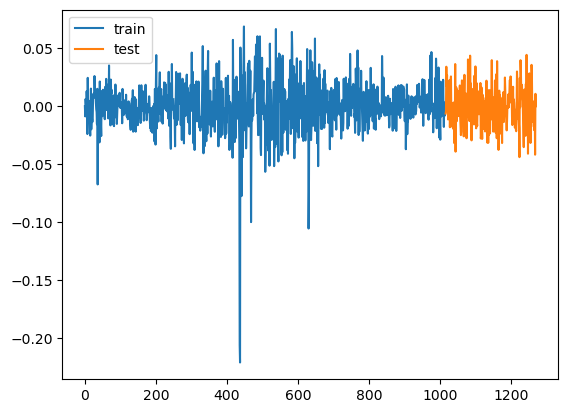

In [62]:
fig, ax = plt.subplots()
x1 = np.arange(len(ret_train))
x2 = np.arange(len(ret_train), len(ret_train) + len(ret_test))
ax.plot(x1, ret_train, label="train")
ax.plot(x2, ret_test, label="test")
ax.legend()
plt.show()

In [64]:
def create_X_y(returns: np.array, window=15):
    X = []
    Y = []
    for i in range(len(returns) - window):
        x = np.array(returns[i: i + window]).reshape(window, 1)
        y = returns[i + window]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [66]:
X_train, y_train = create_X_y(returns)

In [68]:
X_train.shape

(1256, 15, 1)

In [69]:
X_train[0]

array([[ 0.        ],
       [-0.00876646],
       [ 0.00626956],
       [ 0.00074971],
       [-0.00350348],
       [ 0.01295162],
       [ 0.00271838],
       [-0.02397711],
       [ 0.02447059],
       [-0.00172812],
       [ 0.0049297 ],
       [-0.00024588],
       [-0.00344919],
       [-0.00643726],
       [-0.01526744]])